# Model evaluation and selection

In [2]:
import numpy as np
import tensorflow as tf

# for building linear regression models and preparing data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# custom functions
import utils

# reduce display precision on numpy arrays
np.set_printoptions(precision=2)

# suppress warnings
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)


In [3]:
# Load the dataset from the text file
data = np.loadtxt('./data/data_w3_ex1.csv', delimiter=',')

# Split the inputs and outputs into separate arrays
x = data[:,0]
y = data[:,1]

# Convert 1-D arrays into 2-D because the commands later will require it
x = np.expand_dims(x, axis=1)
y = np.expand_dims(y, axis=1)

print(f"the shape of the inputs x is: {x.shape}")
print(f"the shape of the targets y is: {y.shape}")

the shape of the inputs x is: (50, 1)
the shape of the targets y is: (50, 1)


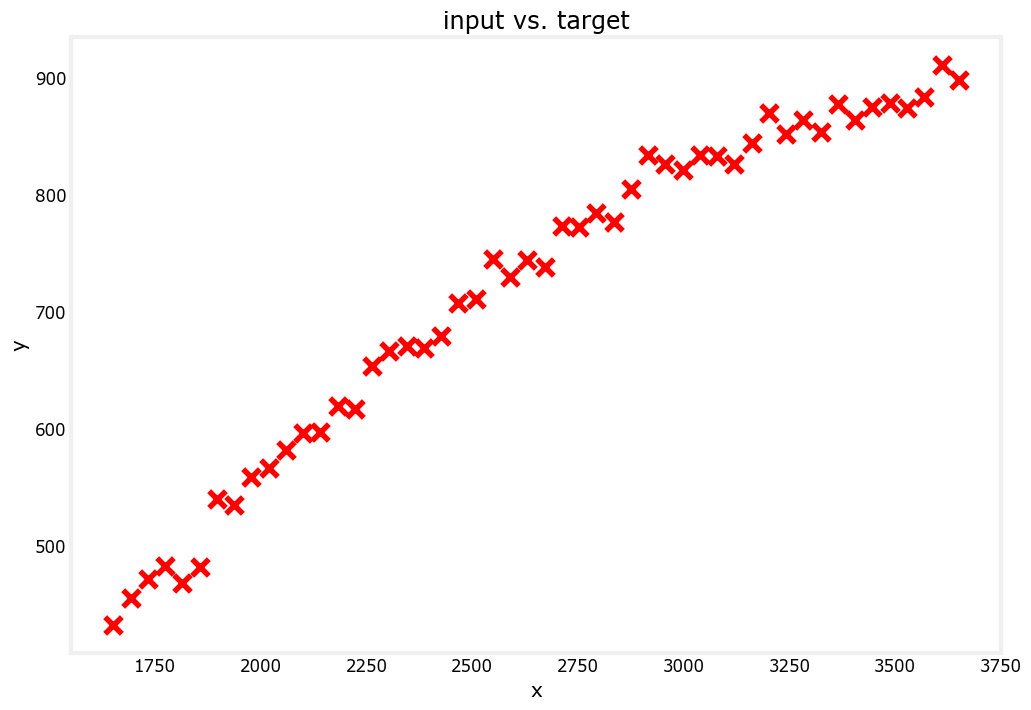

In [4]:
utils.plot_dataset(x=x, y=y, title="input vs. target")

In [5]:
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (30, 1)
the shape of the training set (target) is: (30, 1)

the shape of the cross validation set (input) is: (10, 1)
the shape of the cross validation set (target) is: (10, 1)

the shape of the test set (input) is: (10, 1)
the shape of the test set (target) is: (10, 1)


## feature scaling

In [6]:
# Initialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_scaled = scaler_linear.fit_transform(x_train)

print(f"Computed mean of the training set: {scaler_linear.mean_.squeeze():.2f}")
print(f"Computed standard deviation of the training set: {scaler_linear.scale_.squeeze():.2f}")



# utils.plot_train_cv_test(x_train, y_train, x_cv, y_cv, x_test, y_test, title="input vs. target")

Computed mean of the training set: 2504.06
Computed standard deviation of the training set: 574.85


## Train the model

In [7]:
# Initialize the class
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train_scaled,y_train)

LinearRegression()

## Evaluate the model

In [8]:
# Feed the scaled training set and get the predictions
yhat = linear_model.predict(X_train_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"training MSE (using sklearn function): {mean_squared_error(y_train, yhat) / 2}")

total_squared_error = 0.0

for i in range(len(yhat)):
    squared_error_i = (yhat[i] - y_train[i]) ** 2
    total_squared_error += squared_error_i
mse = total_squared_error/(2*len(yhat))

print(f"training MSE (for-loop implementation): {mse.squeeze()}")

training MSE (using sklearn function): 406.19374192533127
training MSE (for-loop implementation): 406.19374192533127


You can then compute the MSE for the cross validation set with basically the same equation:

$$J_{cv}(\vec{w}, b) = \frac{1}{2m_{cv}}\left[\sum_{i=1}^{m_{cv}}(f_{\vec{w},b}(\vec{x}_{cv}^{(i)}) - y_{cv}^{(i)})^2\right]$$

As with the training set, you will also want to scale the cross validation set. An *important* thing to note when using the z-score is you have to use the mean and standard deviation of the **training set** when scaling the cross validation set. This is to ensure that your input features are transformed as expected by the model. One way to gain intuition is with this scenario:

* Say that your training set has an input feature equal to `500` which is scaled down to `0.5` using the z-score.
* After training, your model is able to accurately map this scaled input `x=0.5` to the target output `y=300`. 
* Now let's say that you deployed this model and one of your users fed it a sample equal to `500`. 
* If you get this input sample's z-score using any other values of the mean and standard deviation, then it might not be scaled to `0.5` and your model will most likely make a wrong prediction (i.e. not equal to `y=300`). 

You will scale the cross validation set below by using the same `StandardScaler` you used earlier but only calling its [`transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.transform) method instead of [`fit_transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.fit_transform).

In [9]:
x_cv_scaled = scaler_linear.transform(x_cv)

print(f"Mean used to scale the CV set: {scaler_linear.mean_.squeeze():.2f}")
print(f"Standard deviation used to scale the CV set: {scaler_linear.scale_.squeeze():.2f}") # notice it's the same mean and standard deviation that is used in the training data

yhat = linear_model.predict(x_cv_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")


Mean used to scale the CV set: 2504.06
Standard deviation used to scale the CV set: 574.85
Cross validation MSE: 551.7789026952216


## Adding polynomial features

In [10]:
# It will create a new input feature which has the squared values of the input x (i.e. degree=2).
# Instantiate the class to make polynomial features
poly = PolynomialFeatures(degree=2,include_bias=False)

# Compute the number of features and transform the training set
X_train_mapped = poly.fit_transform(x_train)

# Preview the first 5 elements of the new training set. Left column is `x` and right column is `x^2`
# Note: The `e+<number>` in the output denotes how many places the decimal point should 
# be moved. For example, `3.24e+03` is equal to `3240`
print(X_train_mapped[:5])

[[3.32e+03 1.11e+07]
 [2.34e+03 5.50e+06]
 [3.49e+03 1.22e+07]
 [2.63e+03 6.92e+06]
 [2.59e+03 6.71e+06]]


You will then scale the inputs as before to narrow down the range of values.

In [11]:
# Instantiate the class
scaler_poly = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)

# Preview the first 5 elements of the scaled training set.
print(X_train_mapped_scaled[:5])

[[ 1.43  1.47]
 [-0.28 -0.36]
 [ 1.71  1.84]
 [ 0.22  0.11]
 [ 0.15  0.04]]


You can then proceed to train the model. After that, you will measure the model's performance against the cross validation set. Like before, you should make sure to perform the same transformations as you did in the training set. You will add the same number of polynomial features then scale the range of values.


In [12]:
# Initialize the class
model = LinearRegression()

# Train the model
model.fit(X_train_mapped_scaled,y_train)

# Compute the training MSE
yhat = model.predict(X_train_mapped_scaled)
print(f"Training MSE: {mean_squared_error(y_train, yhat) / 2}")

# Add the polynomial features to the cross validation set
x_cv_mapped = poly.fit_transform(x_cv)

# Scale the cross validation set using the mean and standard deviation of the training set
x_cv_mapped_scaled = scaler_poly.transform(x_cv_mapped)

# Compute the cross validation MSE
yhat = model.predict(x_cv_mapped_scaled)
print(f"CrossValidation MSE: {mean_squared_error(y_cv,yhat)/2}")



Training MSE: 49.11160933402521
CrossValidation MSE: 87.69841211111913


In [13]:
degrees=range(1,11)
print(degrees)

range(1, 11)


You'll notice that the MSEs are significantly better for both the training and cross validation set when you added the 2nd order polynomial. You may want to introduce more polynomial terms and see which one gives the best performance. As shown in class, you can have 10 different models like this:


You can create a loop that contains all the steps in the previous code cells. Here is one implementation that adds polynomial features up to degree=10. We'll plot it at the end to make it easier to compare the results for each model.

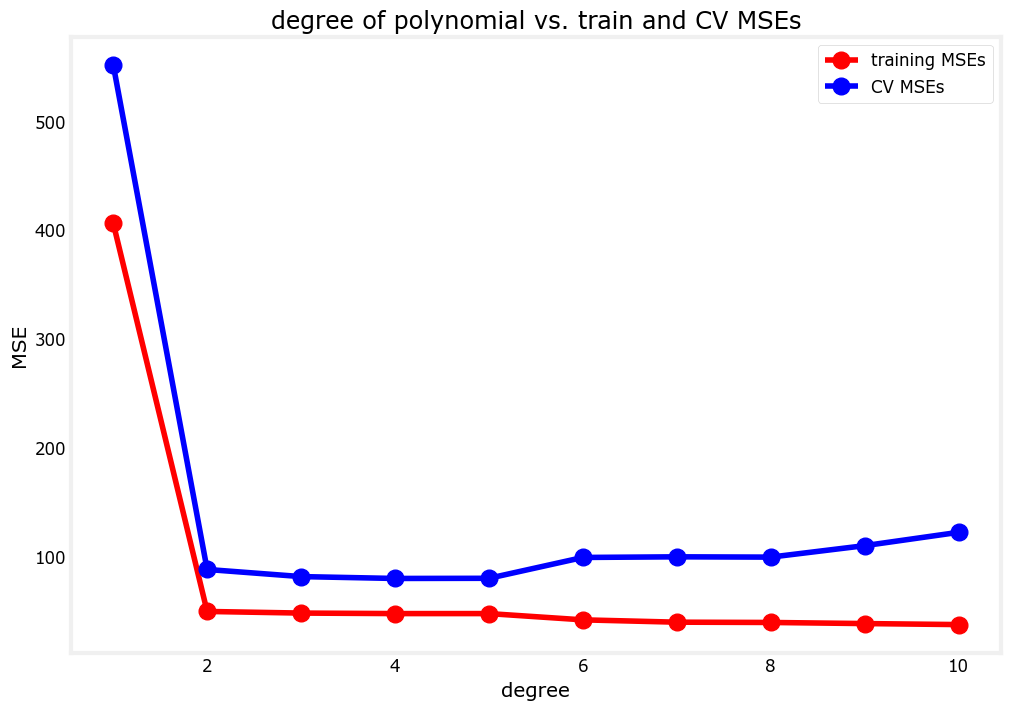

In [14]:
# Initialize lists containing the lists, models, and scalers
train_mses = []
cv_mses = []
models = []
scalers = []

# Loop over 10 times. Each adding one more degree of polynomial higher than the last.
for degree in range(1,11):
    
    # Add polynomial features to the training set
    poly = PolynomialFeatures(degree, include_bias=False)
    X_train_mapped = poly.fit_transform(x_train)
    
    # Scale the training set
    scaler_poly = StandardScaler()
    X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
    scalers.append(scaler_poly)
    
    # Create and train the model
    model = LinearRegression()
    model.fit(X_train_mapped_scaled, y_train )
    models.append(model)
    
    # Compute the training MSE
    yhat = model.predict(X_train_mapped_scaled)
    train_mse = mean_squared_error(y_train, yhat) / 2
    train_mses.append(train_mse)
    
    # Add polynomial features and scale the cross validation set
    poly = PolynomialFeatures(degree, include_bias=False)
    X_cv_mapped = poly.fit_transform(x_cv)
    X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)
    
    # Compute the cross validation MSE
    yhat = model.predict(X_cv_mapped_scaled)
    cv_mse = mean_squared_error(y_cv, yhat) / 2
    cv_mses.append(cv_mse)
    
# Plot the results
degrees=range(1,11)
utils.plot_train_cv_mses(degrees, train_mses, cv_mses, title="degree of polynomial vs. train and CV MSEs")

## Choosing the best model

When selecting a model, you want to choose one that performs well both on the training and cross validation set. It implies that it is able to learn the patterns from your training set without overfitting. If you used the defaults in this lab, you will notice a sharp drop in cross validation error from the models with degree=1 to degree=2. This is followed by a relatively flat line up to degree=5. After that, however, the cross validation error is generally getting worse as you add more polynomial features. Given these, you can decide to use the model with the lowest `cv_mse` as the one best suited for your application.

In [40]:
# Get the model with the lowest CV MSE (add 1 because list indices start at 0)
# This also corresponds to the degree of the polynomial added
degree = np.argmin(cv_mses) + 1
print(f"Lowest CV MSE is found in the model with degree={degree}")

Lowest CV MSE is found in the model with degree=4


You can then publish the generalization error by computing the test set's MSE. As usual, you should transform this data the same way you did with the training and cross validation sets.

In [41]:
# Add polynomial features to the test set
poly = PolynomialFeatures(degree, include_bias=False)
X_test_mapped = poly.fit_transform(x_test)

# Scale the test set
X_test_mapped_scaled = scalers[degree-1].transform(X_test_mapped)

# Compute the test MSE
yhat = models[degree-1].predict(X_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Training MSE: {train_mses[degree-1]:.2f}")
print(f"Cross Validation MSE: {cv_mses[degree-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

Training MSE: 47.15
Cross Validation MSE: 79.43
Test MSE: 104.63


## Neural Networks

### prepare the data

In [46]:
degree = 1
poly = PolynomialFeatures(degree,include_bias=False)
X_train_mapped = poly.fit_transform(x_train)
X_cv_mapped = poly.transform(x_cv)
X_test_mapped = poly.transform(x_test)

Next, you will scale the input features to help gradient descent converge faster. Again, notice that you are using the mean and standard deviation computed from the training set by just using transform() in the cross validation and test sets instead of fit_transform().

In [47]:
# Scale the features using the z-score
standard_scaler = StandardScaler()
X_train_mapped_scaled = standard_scaler.fit_transform(X_train_mapped)
X_cv_mapped_scaled = standard_scaler.transform(X_cv_mapped)
X_test_mapped_scaled = standard_scaler.transform(X_test_mapped)

### Build and train the models

You will then create the neural network architectures shown earlier. The code is provided in the `build_models()` function in the `utils.py` file in case you want to inspect or modify it. You will use that in the loop below then proceed to train the models. For each model, you will also record the training and cross validation errors.

In [48]:
# mean squared erros for training and crossvalidation data sets
nn_mses_train = []
nn_mses_cv = []

# build the models
nn_models = utils.build_models()

for model in nn_models:
    # Specify cost function
    # Setup the loss and optimizer
    model.compile(loss="mse",optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))

    # Train the model
    model.fit(X_train_mapped_scaled,y_train,epochs=300,verbose=0)

    print(f"Training done for {model.name}")

    # Record the training MSEs
    # compute cost for training data
    yhat = model.predict(X_train_mapped_scaled)
    trained_mse = mean_squared_error(y_train,yhat)/2
    nn_mses_train.append(trained_mse)

    # Record the cv MSEs
    # compute cost for cv data
    yhat = model.predict(X_cv_mapped_scaled)
    cv_mse = mean_squared_error(y_cv,yhat)/2
    nn_mses_cv.append(cv_mse)

    print("Done \n")


# print results
print("RESULTS:")
for model_num in range(len(nn_models)):
    print(
        f"Model {model_num+1}: Training MSE: {nn_mses_train[model_num]:.2f}, " +
        f"CV MSE: {nn_mses_cv[model_num]:.2f}"
        )

# Best Performing model
print(f"Best perfroming model is Model: {np.argmin(nn_mses_cv)+1}")



2023-03-26 14:13:45.722545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Training done for model_1
1/1 [==============================] - 0s 16ms/step
Done 



2023-03-26 14:13:47.350717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 14:13:47.633761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Training done for model_2
1/1 [==============================] - 0s 21ms/step
Done 



2023-03-26 14:13:49.603503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 14:13:49.906388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Training done for model_3
1/1 [==============================] - 0s 25ms/step
Done 

RESULTS:
Model 1: Training MSE: 73.44, CV MSE: 113.87
Model 2: Training MSE: 73.40, CV MSE: 112.28
Model 3: Training MSE: 44.56, CV MSE: 88.15
Best perfroming model is Model: 3


2023-03-26 14:13:52.049186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


From the recorded errors, you can decide which is the best model for your application. Look at the results above and see if you agree with the selected `model_num` below. Finally, you will compute the test error to estimate how well it generalizes to new examples.

In [49]:
# Select the model with the lowest CV MSE
model_num = 3

# Compute the test MSE
yhat = nn_models[model_num-1].predict(X_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Selected Model: {model_num}")
print(f"Training MSE: {nn_mses_train[model_num-1]:.2f}")
print(f"Cross Validation MSE: {nn_mses_cv[model_num-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

1/1 [==============================] - 0s 12ms/step
Selected Model: 3
Training MSE: 44.56
Cross Validation MSE: 88.15
Test MSE: 87.20


## Classification

### Load Data

In [76]:
# Load the data set
data = np.loadtxt('./data/data_w3_ex2.csv', delimiter=',')

# Split the inputs and outputs into separate arrays
x_bc = data[:,:-1]
y_bc = data[:,-1:]

print(f"the shape of the inputs x is: {x_bc.shape}")
print(f"the shape of the targets y is: {y_bc.shape}")

the shape of the inputs x is: (200, 2)
the shape of the targets y is: (200, 1)


You can plot the dataset to examine how the examples are separated.

In [ ]:
utils.plot_bc_dataset(x=x_bc, y=y_bc, title="x1 vs. x2")

### Split the dataset

Next, you will generate the training, cross validation, and test sets. You will use the same 60/20/20 proportions as before.

In [78]:
from sklearn.model_selection import train_test_split

# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables.
x_bc_train, x_, y_bc_train, y_ = train_test_split(x_bc, y_bc, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_bc_cv, x_bc_test, y_bc_cv, y_bc_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_bc_train.shape}")
print(f"the shape of the training set (target) is: {y_bc_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_bc_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_bc_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_bc_test.shape}")
print(f"the shape of the test set (target) is: {y_bc_test.shape}")

the shape of the training set (input) is: (120, 2)
the shape of the training set (target) is: (120, 1)

the shape of the cross validation set (input) is: (40, 2)
the shape of the cross validation set (target) is: (40, 1)

the shape of the test set (input) is: (40, 2)
the shape of the test set (target) is: (40, 1)


### Evaluating the error for classification models

In the previous sections on regression models, you used the mean squared error to measure how well your model is doing. For classification, you can get a similar metric by getting the fraction of the data that the model has misclassified. For example, if your model made wrong predictions for 2 samples out of 5, then you will report an error of `40%` or `0.4`. The code below demonstrates this using a for-loop and also with Numpy's [`mean()`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) function. 

In [79]:
# Sample model output
probabilities = np.array([0.2, 0.6, 0.7, 0.3, 0.8])

# Apply a threshold to the model output. If greater than 0.5, set to 1. Else 0.
predictions = np.where(probabilities >= 0.5, 1, 0)

# Ground truth labels
ground_truth = np.array([1, 1, 1, 1, 1])

# Initialize counter for misclassified data
misclassified = 0

# Get number of predictions
num_predictions = len(predictions)

# Loop over each prediction
for i in range(num_predictions):
    
    # Check if it matches the ground truth
    if predictions[i] != ground_truth[i]:
        
        # Add one to the counter if the prediction is wrong
        misclassified += 1

# Compute the fraction of the data that the model misclassified
fraction_error = misclassified/num_predictions

print(f"probabilities: {probabilities}")
print(f"predictions with threshold=0.5: {predictions}")
print(f"targets: {ground_truth}")
print(f"fraction of misclassified data (for-loop): {fraction_error}")
print(f"fraction of misclassified data (with np.mean()): {np.mean(predictions != ground_truth)}")

probabilities: [0.2 0.6 0.7 0.3 0.8]
predictions with threshold=0.5: [0 1 1 0 1]
targets: [1 1 1 1 1]
fraction of misclassified data (for-loop): 0.4
fraction of misclassified data (with np.mean()): 0.4


In [87]:
# classification erros for training and crossvalidation data sets
nn_train_error = []
nn_cv_error = []

# build the models
nn_models = utils.build_models()

def sigmoid(z):
    return 1/(1+np.exp(-z))

for model in nn_models:
    
    # cost function
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

    # train the model
    model.fit(x_bc_train,y_bc_train,epochs=200,verbose=0)

    # Set the threshold for classification
    threshold = 0.5

    # Record the fraction of misclassified examples for the training set
    yhat = model.predict(x_bc_train)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    train_error = np.mean(yhat!=y_bc_train)
    nn_train_error.append(train_error)

    # Record the fraction of misclassified examples for the cross validation set
    yhat = model.predict(x_bc_cv)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= 0.5,1,0)
    cv_error = np.mean(yhat != y_bc_cv)
    nn_cv_error.append(cv_error)

    # Print the result
    for model_num in range(len(nn_train_error)):
        print(
            f"Model {model_num+1}: Training Set Classification Error: {nn_train_error[model_num]:.5f}, " +
            f"CV Set Classification Error: {nn_cv_error[model_num]:.5f}"
            )

# You this is how sigmoid,np.where,and np.mean are calculatin the values

#     pred_train = model.predict(x_bc_train)
#     pred_cv = model.predict(x_bc_cv)

#     train_probabilites = sigmoid(pred_train)
#     cv_probabilites = sigmoid(pred_cv)

#     yhat_train = np.where(train_probabilites>0.5,1,0)
#     yhat_cv = np.where(cv_probabilites>0.5,1,0)

#     print("train data prediction",yhat_train[:5])
#     print("cv data prediction",yhat_cv[:5])

#     # compute the fraction error
#     misclassified_train = 0;
#     misclassified_cv = 0;

#     for i in range(len(yhat_train)):
#         if yhat_train[i] != y_bc_train[i]:
#             misclassified_train+=1
#     for j in range(len(yhat_cv)):
#         if yhat_cv[j] != y_bc_cv[j]:
#             misclassified_cv+=1
        
#     # Compute the fraction of the data that the model misclassified
#     fraction_error_train = misclassified_train/len(yhat_train)
#     fraction_error_cv = misclassified_cv/len(yhat_cv)

#     nn_train_error.append(fraction_error_train)
#     nn_cv_error.append(fraction_error_cv)

# print(nn_train_error)
# print(nn_cv_error)





2023-03-26 17:38:42.988347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 12ms/step


2023-03-26 17:38:47.400452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Model 1: Training Set Classification Error: 0.18333, CV Set Classification Error: 0.10000


2023-03-26 17:38:47.730168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 15ms/step


2023-03-26 17:38:53.000647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Model 1: Training Set Classification Error: 0.18333, CV Set Classification Error: 0.10000
Model 2: Training Set Classification Error: 0.13333, CV Set Classification Error: 0.10000


2023-03-26 17:38:53.362585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 25ms/step
Model 1: Training Set Classification Error: 0.18333, CV Set Classification Error: 0.10000
Model 2: Training Set Classification Error: 0.13333, CV Set Classification Error: 0.10000
Model 3: Training Set Classification Error: 0.17500, CV Set Classification Error: 0.10000


2023-03-26 17:38:59.580221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


From the output above, you can choose which one performed best. If there is a tie on the cross validation set error, then you can pick the one with the lower training set error. Finally, you can compute the test error to report the model's generalization error.

In [88]:
# Select the model with the lowest error
model_num = 2

# Compute the test error
yhat = nn_models[model_num-1].predict(x_bc_test)
yhat = tf.math.sigmoid(yhat)
yhat = np.where(yhat >= threshold, 1, 0)
nn_test_error = np.mean(yhat != y_bc_test)

print(f"Selected Model: {model_num}")
print(f"Training Set Classification Error: {nn_train_error[model_num-1]:.4f}")
print(f"CV Set Classification Error: {nn_cv_error[model_num-1]:.4f}")
print(f"Test Set Classification Error: {nn_test_error:.4f}")

NameError: name 'models_bc' is not defined